# <font style="color:blue">Table of Content</font>



- [1. Training Utils](#utils)
- [2. Model 1: Small Model [S]](#small-model)
- [2.1. Experiment 1: Without Regularization [S]](#S-without)
- [3. Model 2: Medium Model [M]](#medium)
- [3.1. Experiment 2: Without Regularization [M]](#M-without)
- [3.2. Experiment 3: With Batch-Norm [M]](#M-with_BN)
- [3.3 Experiment 4: With Dropout [M]](#M-with_Drop)
- [3.4. Experiment 5: With Batch-Norm and Dropout [M]](#M-with_B_and_Drop)
- [3.5. Experiment 6: Data Augmentation [M]](#M-with_aug)
- [3.6. Experiment 7: Data Augmentation with Batch-Norm and Dropout [M]](#M-with_Aug_and_BN_and_Drop)
- [4. Model 3: Large Model [L]](#Large)
- [4.1. Experiment 8: Data Augmentation With Batch-Norm and Dropout [L]](#L-with_Drop_Aug_BN)
- [5. Loss and Accuracy Plot of All Experiments](#plots)
- [6. Conclusion](#conclusion)
- [Exercise](#exercise)

# <font style="color:blue">Training With Regularization</font>

We have already covered the theory of bias, variance, and different regularization techniques. 

In this notebook, you will learn  to use these concepts to improve our model. Techniques used:

1. Batch-Norm


2. Dropout


3. Data augmentation

We will illustrate the different techniques using the "Fashion MNIST" dataset and the `LambdaLR` scheduler with `SGD`.

**We will experiment with the following:**

1. **A Small Model:** Start with a small CNN (**`SmallModel` \[S\]**), which reaches an accuracy of around `90%`. Note that even the training accuracy is not very high. It means that the LeNet model is not complex enough to overfit (get almost 100% accuracy on training data, or around zero loss on training data). Going by the definition of bias and variance, this model has high bias and variance.


2. **A Larger Model:** So,we need a deeper and wider model. Accordingly, we create one bigger model (**`MediumModel` \[M\]**). Also, in order to conduct all our  experiments, this model has to be configurable. Such that we can specify options for `Dropout/Batch Norm` etc.


3. **Without any Regularization:** First, try the `MediumModel` without any regularization (no Dropout,  Batch Norm, Data augmentation or L2-penalty). We find that that model overfits (around `100 %` training accuracy, but only `92-93 %` for validation). This model has low bias and high variance. We therefore need to use   regularization techniques to reduce this high variance.


4. **With Batch Normalization:** Start with Batch Norm regularization. You will notice that the accuracy improves slightly. Also, the  loss decreases. Even if accuracy does not improve and only the loss decreases, it still means this is a more robust model (misclassification confidence will not be very high).


5. **With Dropout Regularization:** Explore Dropout, without Batch norm. You find that with the Dropout, accuracy remains almost the same but loss improves. 


6. **With combined Dropout and Batch Norm:** Now, consider Batch Norm with Dropout. In terms of accuracy and loss, these cases turn out to be slightly better than the ones above.,when we measure.


7. **With Data Augmentation:** Next, explore the Data augmentation technique. Start without Batch  Norm or Dropout. Implemented alone, Data augmentation turns out to be better than all the above techniques. Why is it so? That’s because it is a virtual way to increase the number of training data, which in turn, helps in model generalization. 


8. **With all three techniques:** Now, try using both Batch Norm and Dropout with Data augmentation. It  works better than all the above. At the same time, you will notice that train loss  decreases till the last epoch (60 epoch), but is higher than the validation loss, although validation loss is not decreasing. This means there is no point increasing the total number of epochs, The validation loss is unlikely to decrease.


9. **With an even Larger Model:** Let’s now create one complex model ((**LargeModel \[L\]**, by increasing the number of filters) and explore Data augmentation along with Batch Norm and Dropout. This turns out to be the best technique.


# <font style="color:blue">1. Training Utils</font><a name="utils"></a>

In [7]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt  # one of the best graphics library for python
plt.style.use('ggplot')

In [9]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

## <font style="color:green">1.1. Fashion MNIST Data With Optional Data Augmentation</font>


You already know the `get_data` method. Now, modify this method to generate augmented data. Use the `data_augmentation` argument to switch on-off the augmentation.


For Data Augmentation, do the following:

- Random Horizontal Flip


- Random Vertical Flip


- Random Rotation

In [10]:
def get_data(batch_size, data_root='data', num_workers=1, data_augmentation=False):
    
    # common transforms
    common_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.2860, ), (0.3530, ))
    ])
    
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20, fill=(0,)),
                transforms.RandomCrop(28, padding=4)
            ]),
            transforms.ToTensor(),
            transforms.Normalize((0.2860, ), (0.3530, ))
        ])
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    
    # train dataloader
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # test dataloader
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=common_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

## <font style="color:green">1.2. System Configuration</font>

In [11]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

## <font style="color:green">1.3. Training Configuration</font>

In [12]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32  
    epochs_count: int = 60
    init_learning_rate: float = 0.02  # initial learning rate for lr scheduler
    decay_rate: float = 0.1  
    log_interval: int = 500  
    test_interval: int = 1  
    data_root: str = "./data" 
    num_workers: int = 10  
    device: str = 'cuda'  
    


## <font style="color:green">1.4. System Setup</font>

In [13]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">1.5. Training Function</font>

You are familiar with the training pipeline used in PyTorch.

In [14]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mode
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (it is mandatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gradients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])

#         if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
#             print(
#                 'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
#                     epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
#                 )
#             )
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} Train Loss: {:.6f} Acc: {:.4f}'.format(
                epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:green">1.6. Validation Function</font>

In [15]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # get probability score using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:green">1.7. Main Function for Training and Validation</font>

For this, use the configuration parameters defined above, and start training. Action points in the code below:

1. Set up system parameters like CPU/GPU, number of threads etc.


2. Load the data using dataloaders.


3. For each epoch, call  the train function. For every test interval, call validation.



4. Do `scheduler.step()` to update the learning rate for next epoch.


5. Set up variables to track loss and accuracy and start training.

In [16]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=False):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lower batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 2

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epoch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # training time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
        
        # scheduler step/ update learning rate
        if scheduler is not None:
            scheduler.step()
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:green">1.8. Optimizer and Scheduler</font>

Let's write optimizer and scheduler as a method because we have to use it in all training experiments. 

In [17]:
def get_optimizer_and_scheduler(model):
    train_config = TrainingConfiguration()

    init_learning_rate = train_config.init_learning_rate

    # optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr = init_learning_rate,
        momentum = 0.9
    )

    decay_rate = train_config.decay_rate

    lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

    # Scheduler
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)
    
    return optimizer, scheduler
    


## <font style="color:green">1.9. Plot Loss and Accuracy</font>

In [38]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors, model_sizes, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=15,
                       fig_size=(16, 8), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="[{2}] TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i], model_sizes[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="[{2}] VALID ({0:.4}): {1}".format(min_val_loss, labels[i], model_sizes[i]))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="[{2}] TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i], model_sizes[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="[{2}] VALID ({0:.4}): {1}".format(max_val_acc, labels[i], model_sizes[i]))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')
    
    plt.show()
    
    return   

# <font style="color:blue">2. Model 1: Small Model [S]</font> <a name="small-model"></a>

A smaller model compared to the `LeNet` Network, let’s check out how much it can learn!


In [19]:
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=8 * 5 * 5, out_features=100), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=100, out_features=50), 
            nn.ReLU(inplace=True),
            
            nn.Linear(in_features=50, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

## <font style="color:green">2.1. Experiment 1: Without Regularization [S]</font><a name="S-without"></a>

In [ ]:
model = SmallModel()
print(model)

# get optimizer and scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# train and validate
model, train_loss_exp1, train_acc_exp1, val_loss_exp1, val_acc_exp1 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)



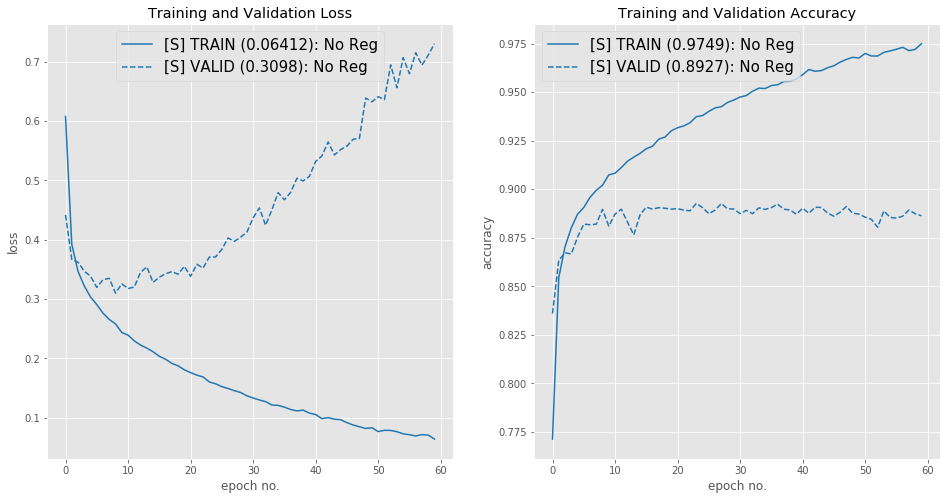

In [48]:
plot_loss_accuracy(train_loss=[train_loss_exp1], 
                   val_loss=[val_loss_exp1], 
                   train_acc=[train_acc_exp1], 
                   val_acc=[val_acc_exp1], 
                   labels=['No Reg'], 
                   colors=['blue'], 
                   model_sizes=['S'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

You can see that it has almost reached its learning capacity and starts overfitting, if when we continue training it.

# <font style="color:blue">3. Model 2: Medium Model [M]</font><a name="medium"></a>

This is a larger model `MediumModel`.  You can use `dropout` or `batch-norm` or both. Just specify. Use this network to see the effects of overfitting and regularization.

In [ ]:
class MediumModel(nn.Module):
    def __init__(self, dropout=0.0, batch_norm=False):
        super().__init__()

        # convolution layers
        if batch_norm:
            self._body = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
                nn.BatchNorm2d(16),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
            )
        else:
             self._body = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
            )
            
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=64 * 4 * 4, out_features=512), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=512, out_features=128), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

## <font style="color:green">3.1. Experiment 2: Without Regularization [M]</font><a name="M-without"></a>

In [ ]:
model = MediumModel()
print(model)

# get optimizer and scheduler
optimizer, scheduler = get_optimizer_and_scheduler(model)

# train and validate
model, train_loss_exp2, train_acc_exp2, val_loss_exp2, val_acc_exp2 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)

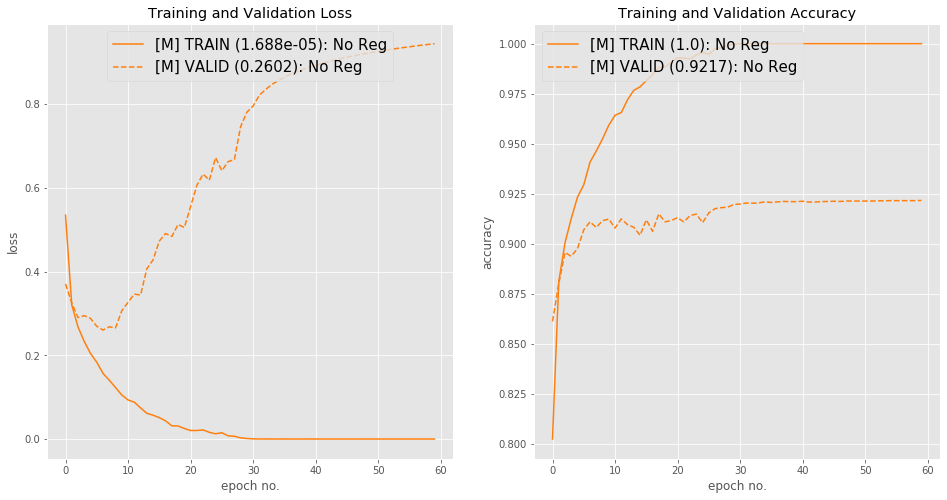

In [47]:
plot_loss_accuracy(train_loss=[train_loss_exp2], 
                   val_loss=[val_loss_exp2], 
                   train_acc=[train_acc_exp2], 
                   val_acc=[val_acc_exp2], 
                   labels=['No Reg'], 
                   colors=['orange'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

Here, you can see that the network has reached a training accuracy of `1` and a training loss of almost `0`. This indicates the network has the required capacity. But do note that the validation loss and accuracy are nowhere close to the training percentages. This means the model is trying to memorize the training data. Rectify this, using the regularization techniques you have learnt so far.

## <font style="color:green">3.2. Experiment 3: With Batch-Norm [M]</font><a name="M-with_BN"></a>

Batch norm is familiar. Now, see if it can reduce overfitting. Add batch normalization to the network and train it.

In [ ]:
model = MediumModel(batch_norm=True)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp3, train_acc_exp3, val_loss_exp3, val_acc_exp3 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)

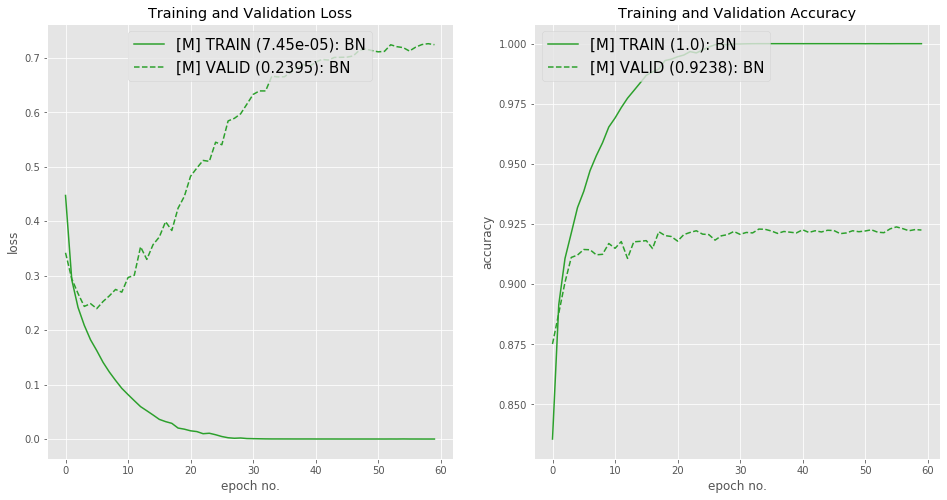

In [46]:
plot_loss_accuracy(train_loss=[train_loss_exp3], 
                   val_loss=[val_loss_exp3], 
                   train_acc=[train_acc_exp3], 
                   val_acc=[val_acc_exp3], 
                   labels=['BN'], 
                   colors=['green'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

## <font style="color:green">3.3 Experiment 4: With Dropout [M]</font><a name="M-with_Drop"></a>

Add Dropout Regularization. Add dropout layers with probability, `0.25`.

In [ ]:
model = MediumModel(0.25)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp4, train_acc_exp4, val_loss_exp4, val_acc_exp4 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)

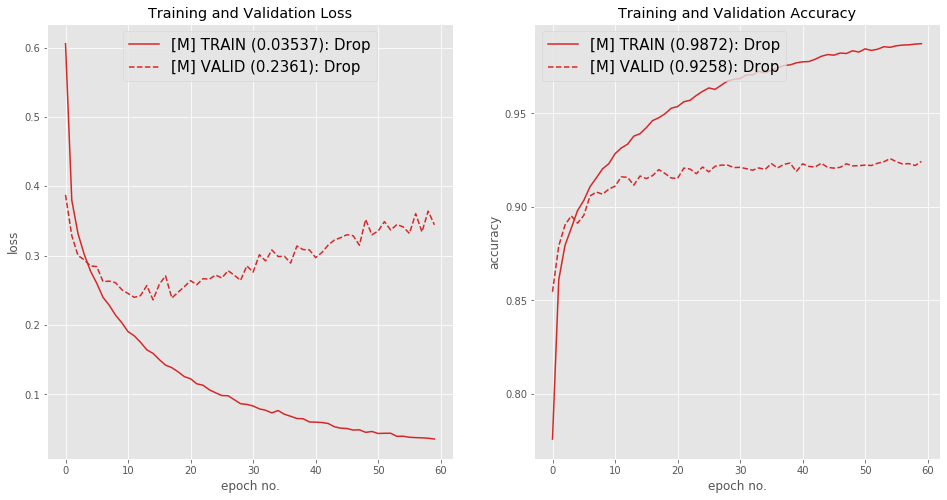

In [45]:
plot_loss_accuracy(train_loss=[train_loss_exp4], 
                   val_loss=[val_loss_exp4], 
                   train_acc=[train_acc_exp4], 
                   val_acc=[val_acc_exp4], 
                   labels=['Drop'], 
                   colors=['red'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

It’s clear that the addition of Dropout  layer effects the validation curves substantially more than Batch Norm. Think of it as training the network on missing data. So, it learns more robust features.

## <font style="color:green">3.4. Experiment 5: With Batch-Norm and Dropout [M]</font><a name="M-with_B_and_Drop"></a>

Apply both Batch Norm and Dropout. See the effect of this double dose.

In [ ]:
model = MediumModel(0.25, batch_norm=True)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp5, train_acc_exp5, val_loss_exp5, val_acc_exp5 = main(model, 
                                                                           optimizer, 
                                                                           scheduler)

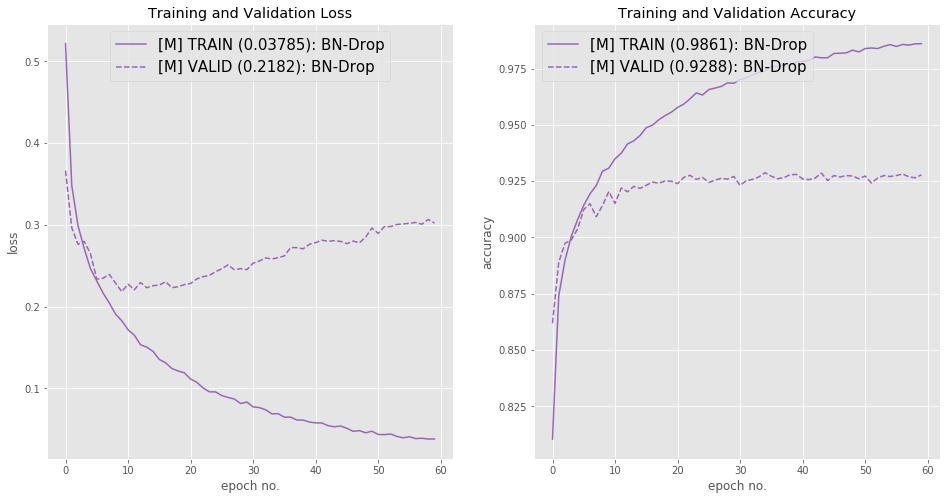

In [44]:
plot_loss_accuracy(train_loss=[train_loss_exp5], 
                   val_loss=[val_loss_exp5], 
                   train_acc=[train_acc_exp5], 
                   val_acc=[val_acc_exp5], 
                   labels=['BN-Drop'], 
                   colors=['purple'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

There is a mild improvement, if we add both. However, it can be tricky,  so always check each , separately.

## <font style="color:green">3.5. Experiment 6: Data Augmentation [M]</font><a name="M-with_aug"></a>

Finally, add Data augmentation. This should have a substantial effect on the validation curves  because we are actually training it on more data.

**NOTE:** Data augmentation, unlike the other two techniques, is not added to the network with. This method increases the data while training, by creating transformations out of the original data. We thus use the `get_data` function to add `data_augmentation`. Pass the required argument to the function. Data augmentation generates the data passed to the training routine with. Do check out the code to see what types of augmentation we are doing.

In [ ]:
model = MediumModel()
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp6, train_acc_exp6, val_loss_exp6, val_acc_exp6 = main(model, 
                                                                           optimizer, 
                                                                           scheduler, 
                                                                           data_augmentation=True)

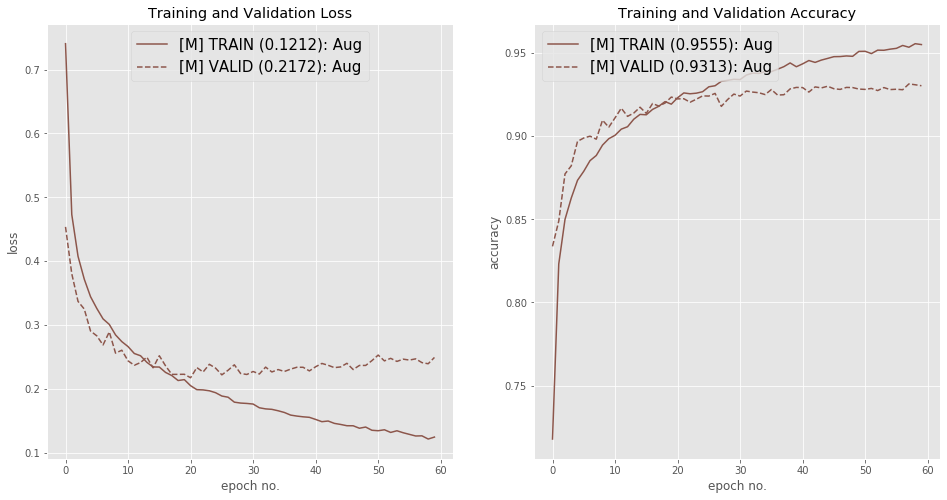

In [43]:
plot_loss_accuracy(train_loss=[train_loss_exp6], 
                   val_loss=[val_loss_exp6], 
                   train_acc=[train_acc_exp6], 
                   val_acc=[val_acc_exp6], 
                   labels=['Aug'], 
                   colors=['brown'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

You can see that there is a huge improvement in validation loss and accuracy.

## <font style="color:green">3.6. Experiment 7: Data Augmentation with Batch-Norm and Dropout [M]</font><a name="M-with_Aug_and_BN_and_Drop"></a>

Why stop at Data augmentation? Let us add Dropout as well as Batch Norm to the pipeline, and make it even more robust!


In [ ]:
model = MediumModel(0.25, batch_norm=True)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp7, train_acc_exp7, val_loss_exp7, val_acc_exp7 = main(model, 
                                                                           optimizer, 
                                                                           scheduler, 
                                                                           data_augmentation=True)

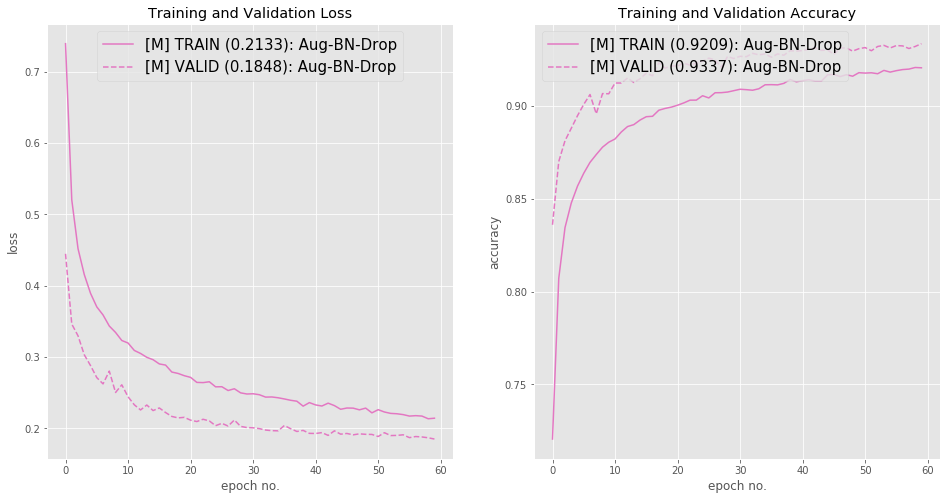

In [42]:
plot_loss_accuracy(train_loss=[train_loss_exp7], 
                   val_loss=[val_loss_exp7], 
                   train_acc=[train_acc_exp7], 
                   val_acc=[val_acc_exp7], 
                   labels=['Aug-BN-Drop'], 
                   colors=['pink'], 
                   model_sizes=['M'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">4. Model 3: Large Model [L]</font><a name="Large"></a>

In the  final step, let's take a larger model and see if we can further  improve the metrics.


In [ ]:
class LargeModel(nn.Module):
    def __init__(self, dropout=0.0, batch_norm=False):
        super().__init__()

        # convolution layers
        if batch_norm:
            self._body = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
            )
        else:
            self._body = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),

                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2),
                nn.Dropout(dropout)
            )
            
        
        # Fully connected layers
        self._head = nn.Sequential(
            
            nn.Linear(in_features=128 * 7 * 7, out_features=2048), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=2048, out_features=256), 
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(in_features=256, out_features=10)
        )

    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

## <font style="color:green">4.1. Experiment 8: Data Augmentation With Batch-Norm and Dropout [L]</font><a name="L-with_Drop_Aug_BN"></a>

In [ ]:
model = LargeModel(0.25, batch_norm=True)
print(model)

optimizer, scheduler = get_optimizer_and_scheduler(model)

model, train_loss_exp8, train_acc_exp8, val_loss_exp8, val_acc_exp8 = main(model, 
                                                                               optimizer, 
                                                                               scheduler, 
                                                                               data_augmentation=True)

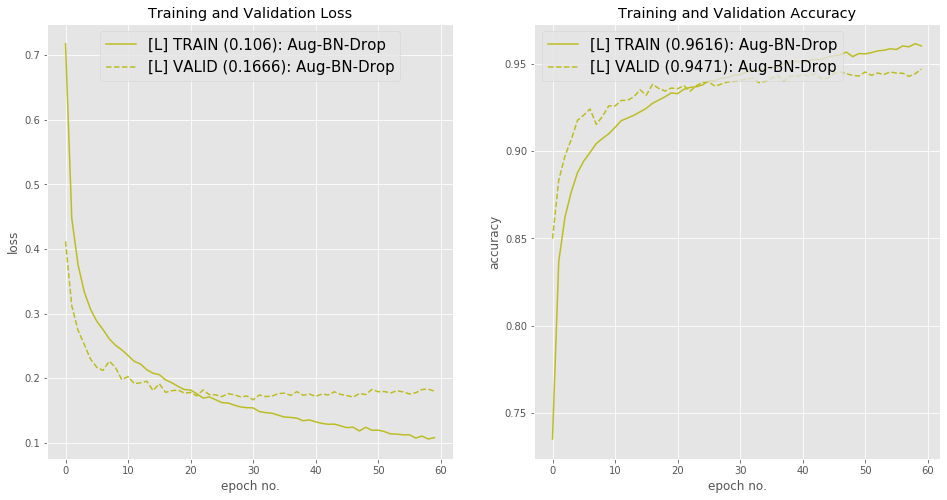

In [41]:
plot_loss_accuracy(train_loss=[train_loss_exp8], 
                   val_loss=[val_loss_exp8], 
                   train_acc=[train_acc_exp8], 
                   val_acc=[val_acc_exp8], 
                   labels=['Aug-BN-Drop'], 
                   colors=['olive'], 
                   model_sizes=['L'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

# <font style="color:blue">5. Loss and Accuracy Plot of All Experiments</font><a name="plots"></a>

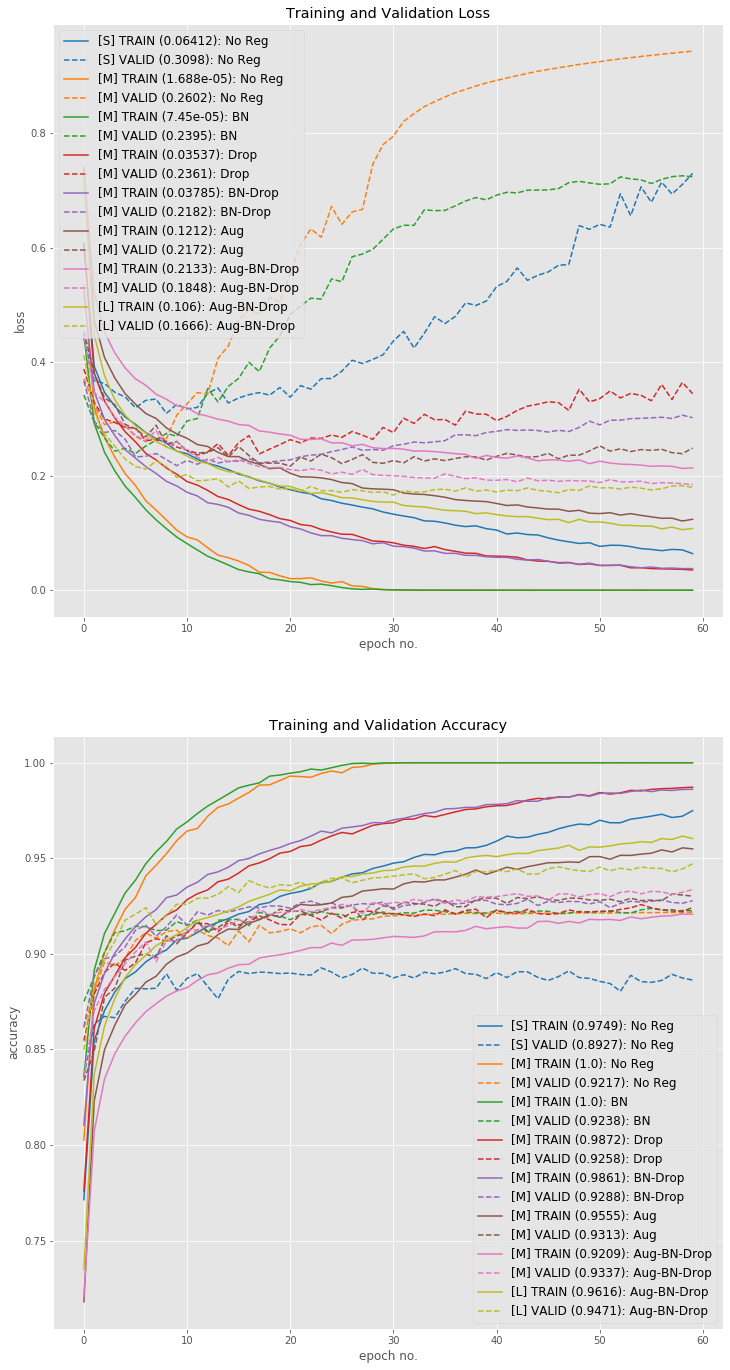

In [40]:
plot_loss_accuracy(train_loss=[train_loss_exp1, train_loss_exp2, train_loss_exp3, train_loss_exp4, 
                               train_loss_exp5, train_loss_exp6, train_loss_exp7, train_loss_exp8], 
                   val_loss=[val_loss_exp1, val_loss_exp2, val_loss_exp3, val_loss_exp4,
                             val_loss_exp5, val_loss_exp6, val_loss_exp7, val_loss_exp8], 
                   train_acc=[train_acc_exp1, train_acc_exp2, train_acc_exp3, train_acc_exp4, 
                              train_acc_exp5, train_acc_exp6, train_acc_exp7, train_acc_exp8], 
                   val_acc=[val_acc_exp1, val_acc_exp2, val_acc_exp3, val_acc_exp4, 
                            val_acc_exp5, val_acc_exp6, val_acc_exp7, val_acc_exp8], 
                   labels=['No Reg', 'No Reg', 'BN', 'Drop', 'BN-Drop', 'Aug', 'Aug-BN-Drop', 'Aug-BN-Drop'], 
                   colors=['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'olive'], 
                   model_sizes=['S', 'M', 'M', 'M', 'M', 'M', 'M', 'L'], 
                   loss_legend_loc='upper left', 
                   acc_legend_loc='best', 
                   legend_font = 12,
                   fig_size=(12, 24), 
                   sub_plot1=(2, 1, 1), 
                   sub_plot2=(2, 1, 2))

# <font style="color:blue">6. Conclusion</font><a name="conclusion"></a>

Start with a simple model that overfits the training data. 

Then use different regularization techniques, optimizers and schedulers. 

If results are not satisfactory, change the model and experiment again. 

# <font style="color:blue">Exercise</font><a name="exercise"></a>

1. Try with different Dropout values, plot curves to gain more insights on what happens.



2. Add more transforms to data augmentation <a href="https://pytorch.org/vision/stable/transforms.html" target="_blank">Check the complete list</a>.


3. Change the dataset to STL ( `torchvision.datasets.STL` ) and see the results (Note: You need to change the network accordingly).